In [70]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.metrics import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional
from tensorflow.keras.optimizers import SGD
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

import numpy.random as rand
import scipy.stats as stats 
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor 
from sklearn.model_selection import StratifiedKFold
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta, time, datetime
import time
from collections import deque
plt.style.use('ggplot')
import plotly.express as px

In [71]:
amzn_model = keras.models.load_model('C:/Users/seant/stock_analyzer/capstone_3/models')

In [15]:
data = pd.read_csv('C:/Users/seant/stock_analyzer/capstone_3/data/prepped_stock_df.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)

In [2]:
pct_change_df = pd.read_csv('C:/Users/seant/stock_analyzer/capstone_3/data/pct_change_df.csv')

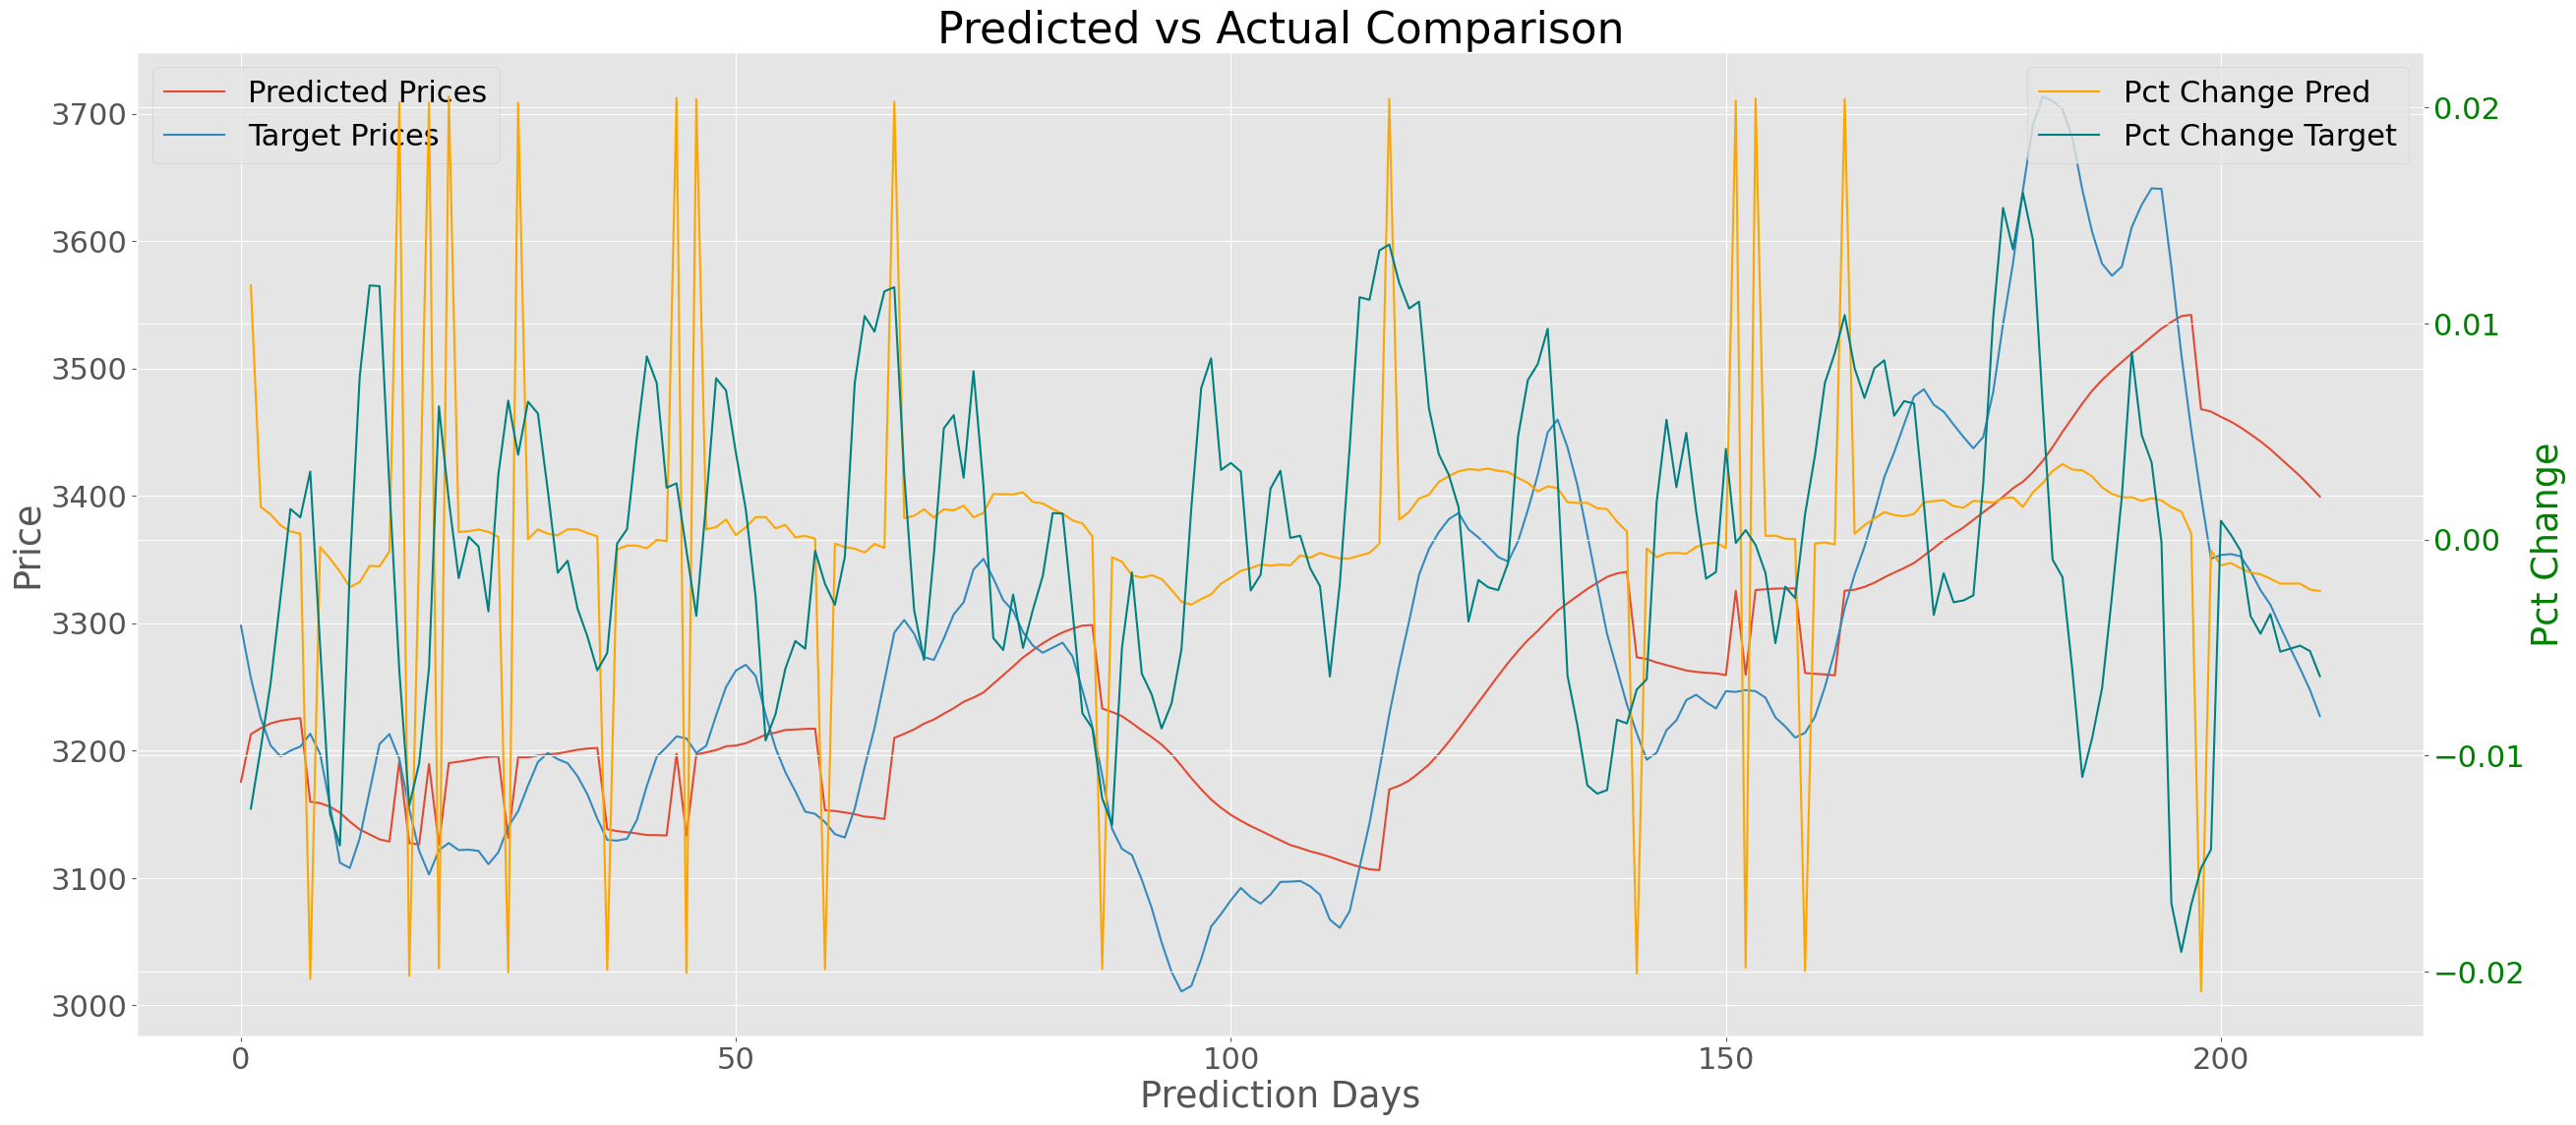

In [3]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(30, 13))
ax.set_title("Predicted vs Actual Comparison")
ax.plot(pct_change_df.loc[:, 'scaled_predictions'])
ax.plot(pct_change_df.loc[:, 'targets'])
ax.legend(['Predicted Prices', 'Target Prices'], loc='upper left')

ax.set_xlabel('Prediction Days')
ax.set_ylabel('Price')

ax2 = ax.twinx()
ax2.plot(pct_change_df.loc[:, 'pct_change_scaled_predictions'], color='orange', label='Pct Change Pred')
ax2.plot(pct_change_df.loc[:, 'pct_change_targets'], color='teal', label='Pct Change Target')
ax2.set_ylabel('Pct Change', color ='g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.legend(loc='upper right')


plt.show()

In [32]:
fig = px.line(pct_change_df, x="Days", y="Price", title='Prection vs Targets Comparison')
fig.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['Unnamed: 0', 'targets', 'scaled_predictions', 'pct_change_targets', 'pct_change_scaled_predictions'] but received: Days

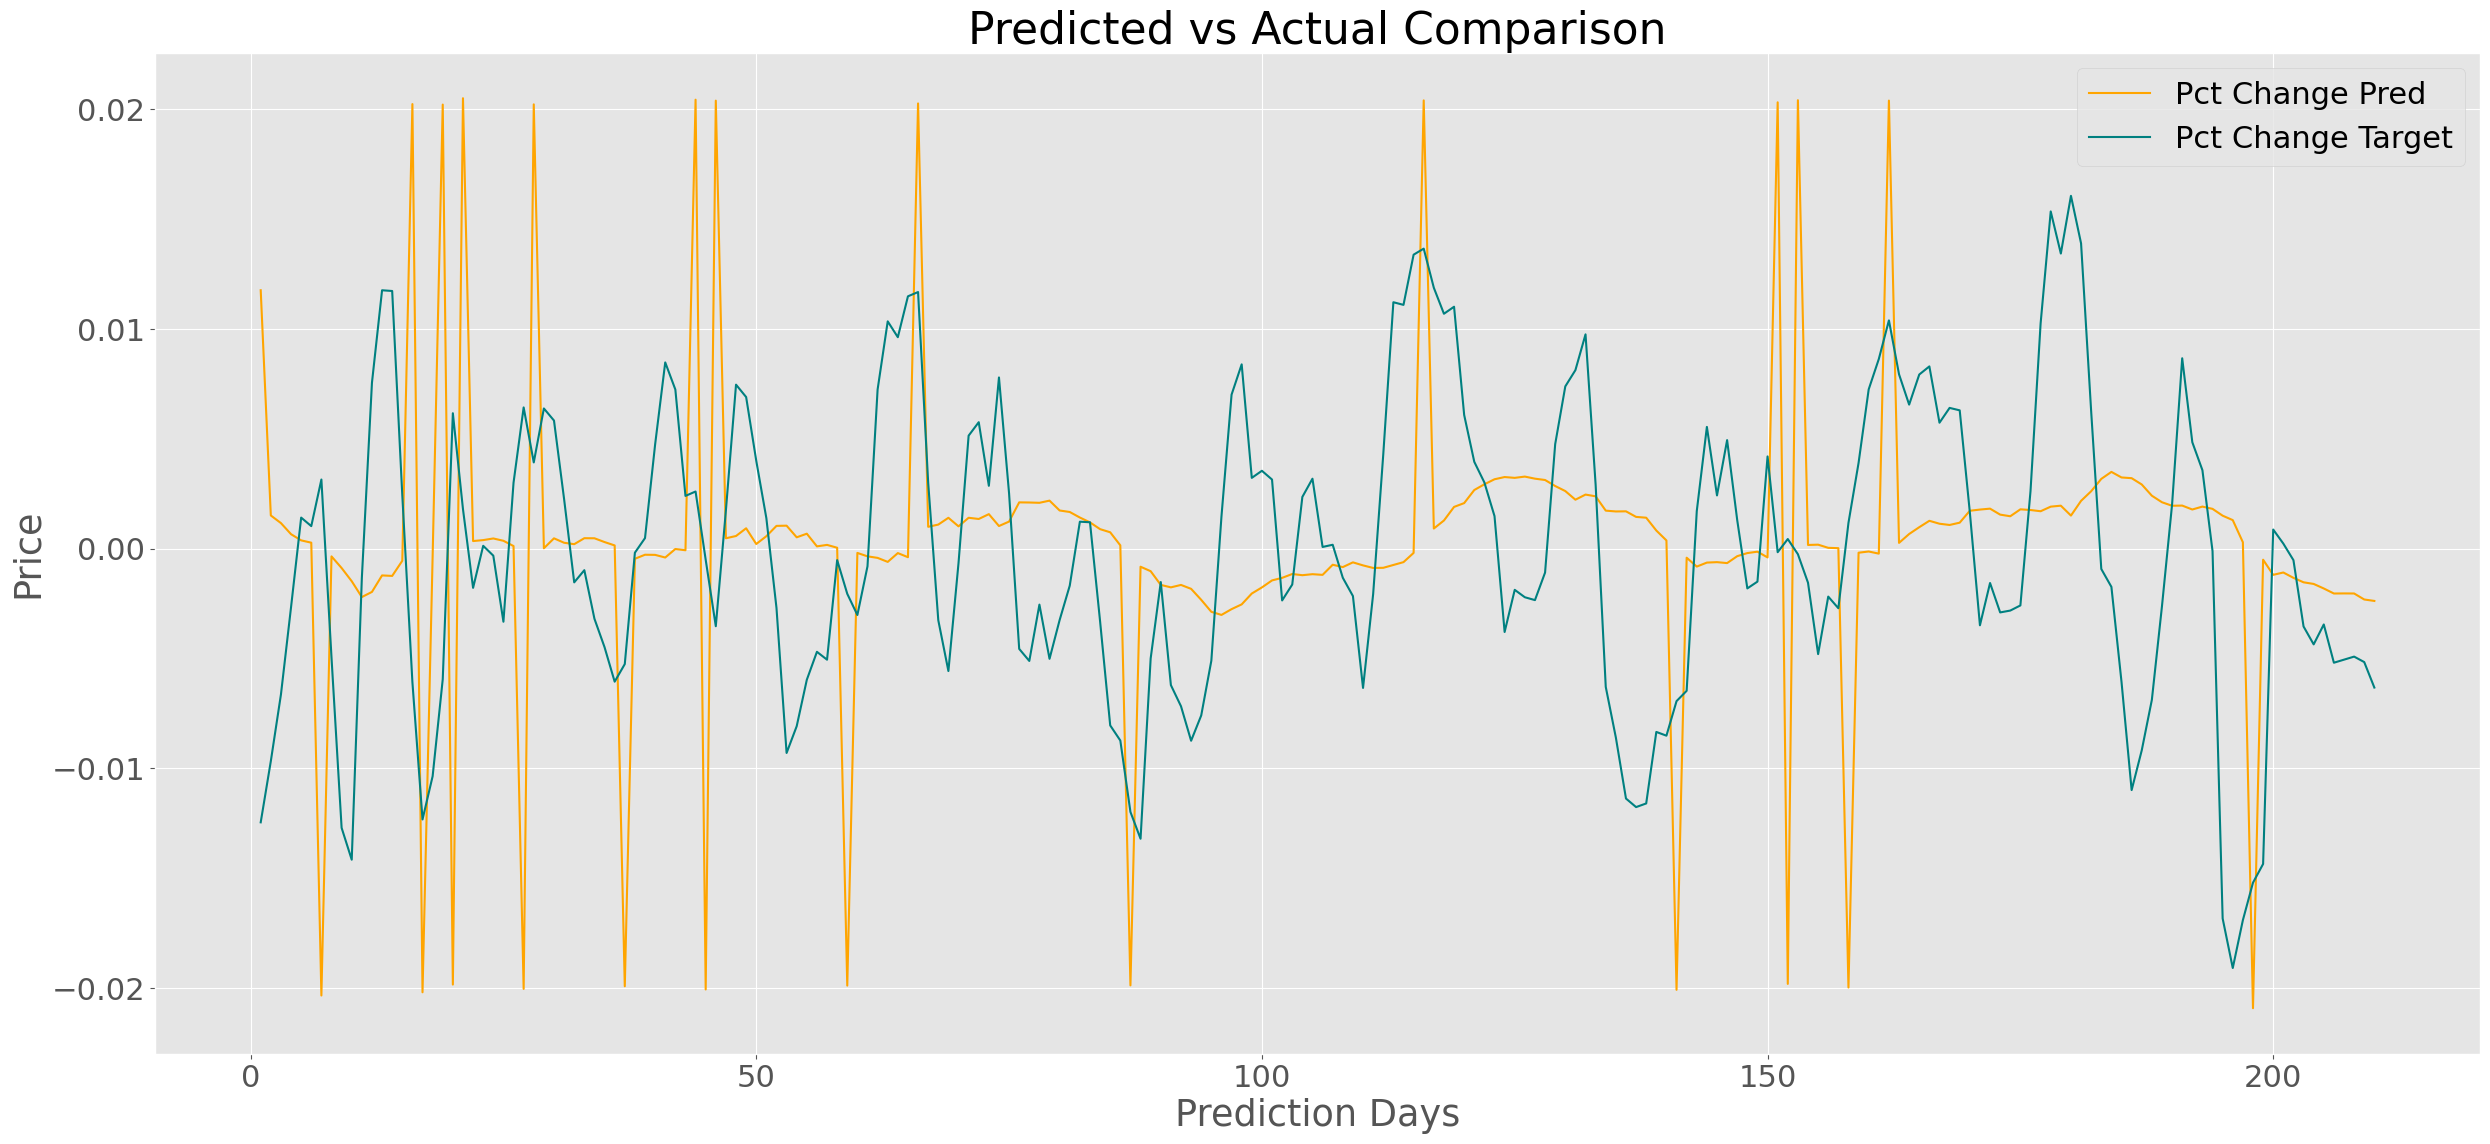

In [6]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(30, 13))
ax.set_title("Predicted vs Actual Comparison")
ax.plot(pct_change_df.loc[:, 'pct_change_scaled_predictions'], color='orange', label='Pct Change Pred')
ax.plot(pct_change_df.loc[:, 'pct_change_targets'], color='teal', label='Pct Change Target')
ax.legend(loc='upper right')

ax.set_xlabel('Prediction Days')
ax.set_ylabel('Price')

plt.show()

In [ ]:
    pos_der_ind = pred_der > 0
    neg_der_ind = pred_der < 0
    scale = 0.01
    endcap = np.array([False])
    pred_copy[np.concatenate([endcap, pos_der_ind])] *= (1 + scale)
    pred_copy[np.concatenate([endcap, neg_der_ind])] *= (1 - scale)

In [7]:
neg_pct_change = pct_change_df.loc[:, 'pct_change_scaled_predictions'] < 0
pos_pct_change = pct_change_df.loc[:, 'pct_change_scaled_predictions'] > 0

In [27]:
def pos_neg_change(df, columns):
    result = pd.DataFrame()
    for column in columns:
        col_copy = df.loc[:, column].copy()
        neg_change_ind = col_copy < 0
        pos_change_ind = col_copy > 0
        col_copy[neg_change_ind] = -1
        col_copy[pos_change_ind] = 1
        col_copy.dropna(inplace=True)
        result.loc[:, column] = col_copy
    return result

In [28]:
result = pos_neg_change(pct_change_df, ['pct_change_scaled_predictions', 'pct_change_targets'])

In [29]:
round(r2_score(result.loc[:, 'pct_change_targets'], result.loc[:, 'pct_change_scaled_predictions']), 3)

-1.119

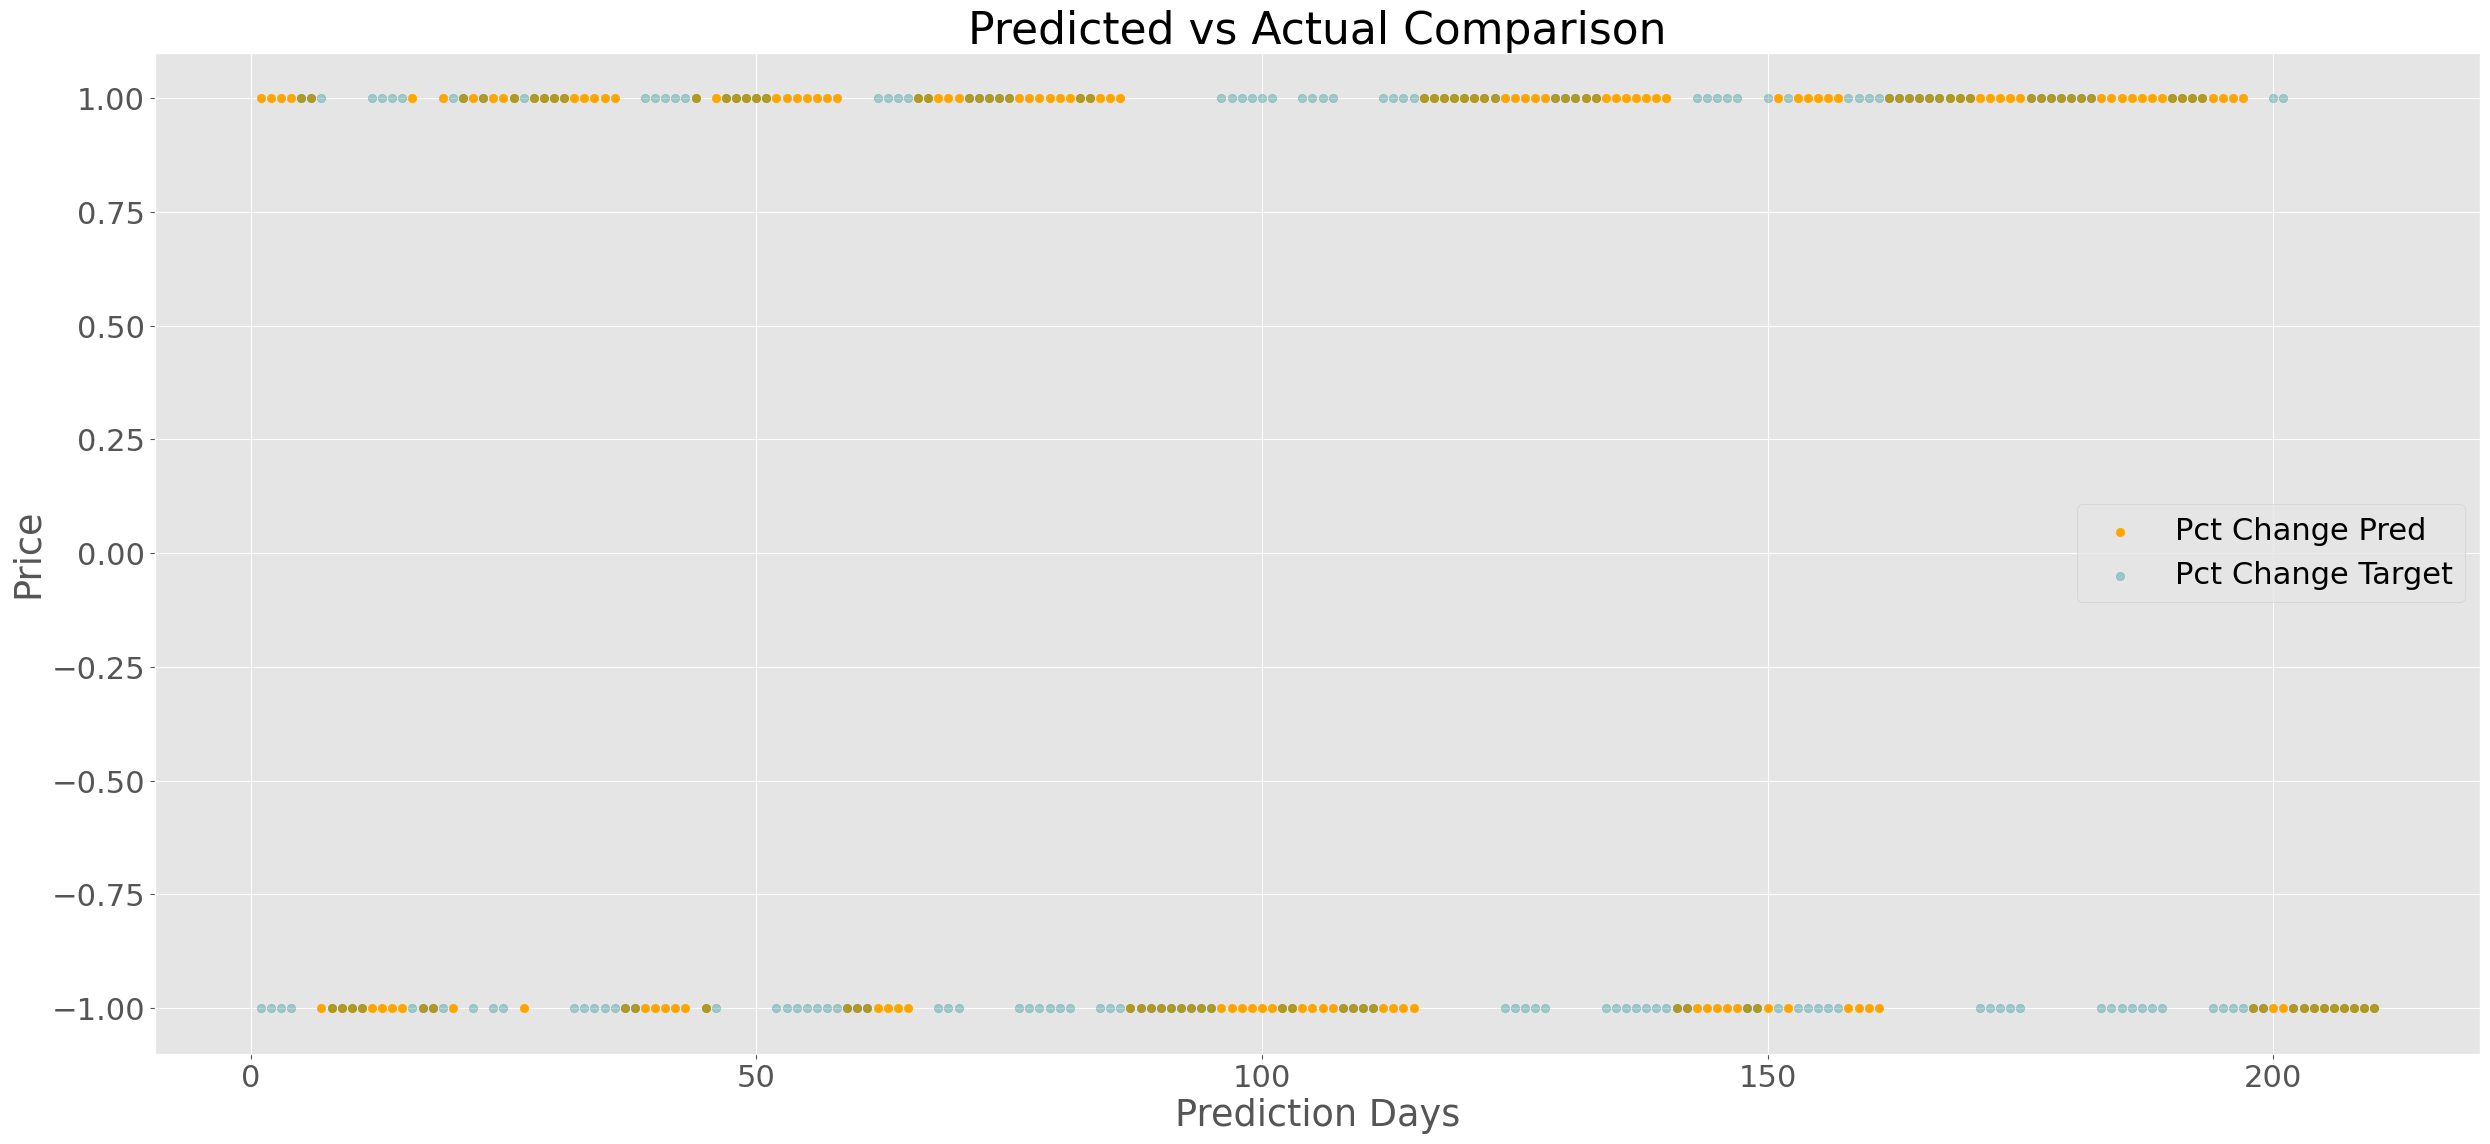

In [30]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(30, 13))
ax.set_title("Predicted vs Actual Comparison")
ax.scatter(result.index, result.loc[:, 'pct_change_scaled_predictions'], color='orange', label='Pct Change Pred')
ax.scatter(result.index, result.loc[:, 'pct_change_targets'], color='teal', alpha=0.3, label='Pct Change Target')
ax.legend()

ax.set_xlabel('Prediction Days')
ax.set_ylabel('Price')

plt.show()

Alert when scaler changes from + to - (or opposite)

increase scaler when scaler change matches sign of change in recent history of actual data (scaler multiplier?)

In [2]:
from data_prep_methods import data_prep

In [3]:
def get_holdout(df, holdout_size=0.2):
    holdout_index = int((1 - 0.2) * df.shape[0])
    data_df = df[:holdout_index].reset_index(drop=True)
    holdout_df  = df[(holdout_index):].reset_index(drop=True)
    return data_df, holdout_df

In [34]:
date = '2021-08-09' #week of 08-09 to 08-13

if data['date_origin'].str.contains(date).any():
    end_idx = data.index[data['date_origin'] == date][0]
    print(end_idx)
    start_idx = end_idx - 50
    data_df = data.iloc[start_idx:end_idx]
    print(data_df.shape)
    target_price = round(data.iloc[end_idx]['AMZN_rolling_close'], 0)
else:
    print('not a correct date')

1247
(50, 11)


In [35]:
test_data = data_prep(data_df)

In [36]:
test_data.data_for_model(columns=['AMZN_vol', 'AMZN_rolling_close', 'GOOG_rolling_close'], test_size=1.0, shuffle=False)

In [37]:
prediction = amzn_model.predict(test_data.result['X_test'])

In [86]:
def scale_result(predictions, targets):
    pred_copy = predictions.copy()
    pred_der = np.diff(pred_copy, n=1, axis=0)
    pos_der_ind = pred_der > 0
    neg_der_ind = pred_der < 0
    
    print(pos_der_ind)
    pct_change = pd.Series(targets).pct_change()
    print(pct_change)
    #check sign of pct change 0-3? indices before change below?
    
    multiplier = 1
    initial_val = pos_der_ind[0]
    change_dic = {}
    for i, val in enumerate(np.nditer(pos_der_ind)):
        if val != initial_val:
            if initial_val == True:
                change_dic[i] = False
                #negative change
            elif initial_val == False:
                change_dic[i] = True
                #positive change
            initial_val = val
    last_change = list(change_dic.keys())[-1]
    if last_change > 3:
        for change in pct_change.iloc[(last_change - 3):last_change]:
            if abs(change) >= 0.1 and change > 0 and change_dic[last_change] == True:
                multiplier += abs(change)
            elif abs(change) >= 0.1 and change < 0 and change_dic[last_change] == False:
                  multiplier += abs(change)
    elif last_change > 1:
        for change in pct_change.iloc[1:last_change]:
            if abs(change) >= 0.1 and change > 0 and change_dic[last_change] == True:
                multiplier += abs(change)
            elif abs(change) >= 0.1 and change < 0 and change_dic[last_change] == False:
                  multiplier += abs(change)
    
    scale = 0.01 * multiplier
    endcap = np.array([False])
    pred_copy[np.concatenate([endcap, pos_der_ind])] *= (1 + scale)
    pred_copy[np.concatenate([endcap, neg_der_ind])] *= (1 - scale)
    return pred_copy

In [87]:
scaled_pred = scale_result(np.squeeze(prediction), test_data.result['y_test'])

[ True  True  True  True False False False False False]
0         NaN
1   -0.001004
2   -0.142301
3   -0.184957
4   -0.197201
5   -0.217143
6   -0.257855
7    0.020589
8    0.005218
9   -0.012331
dtype: float64


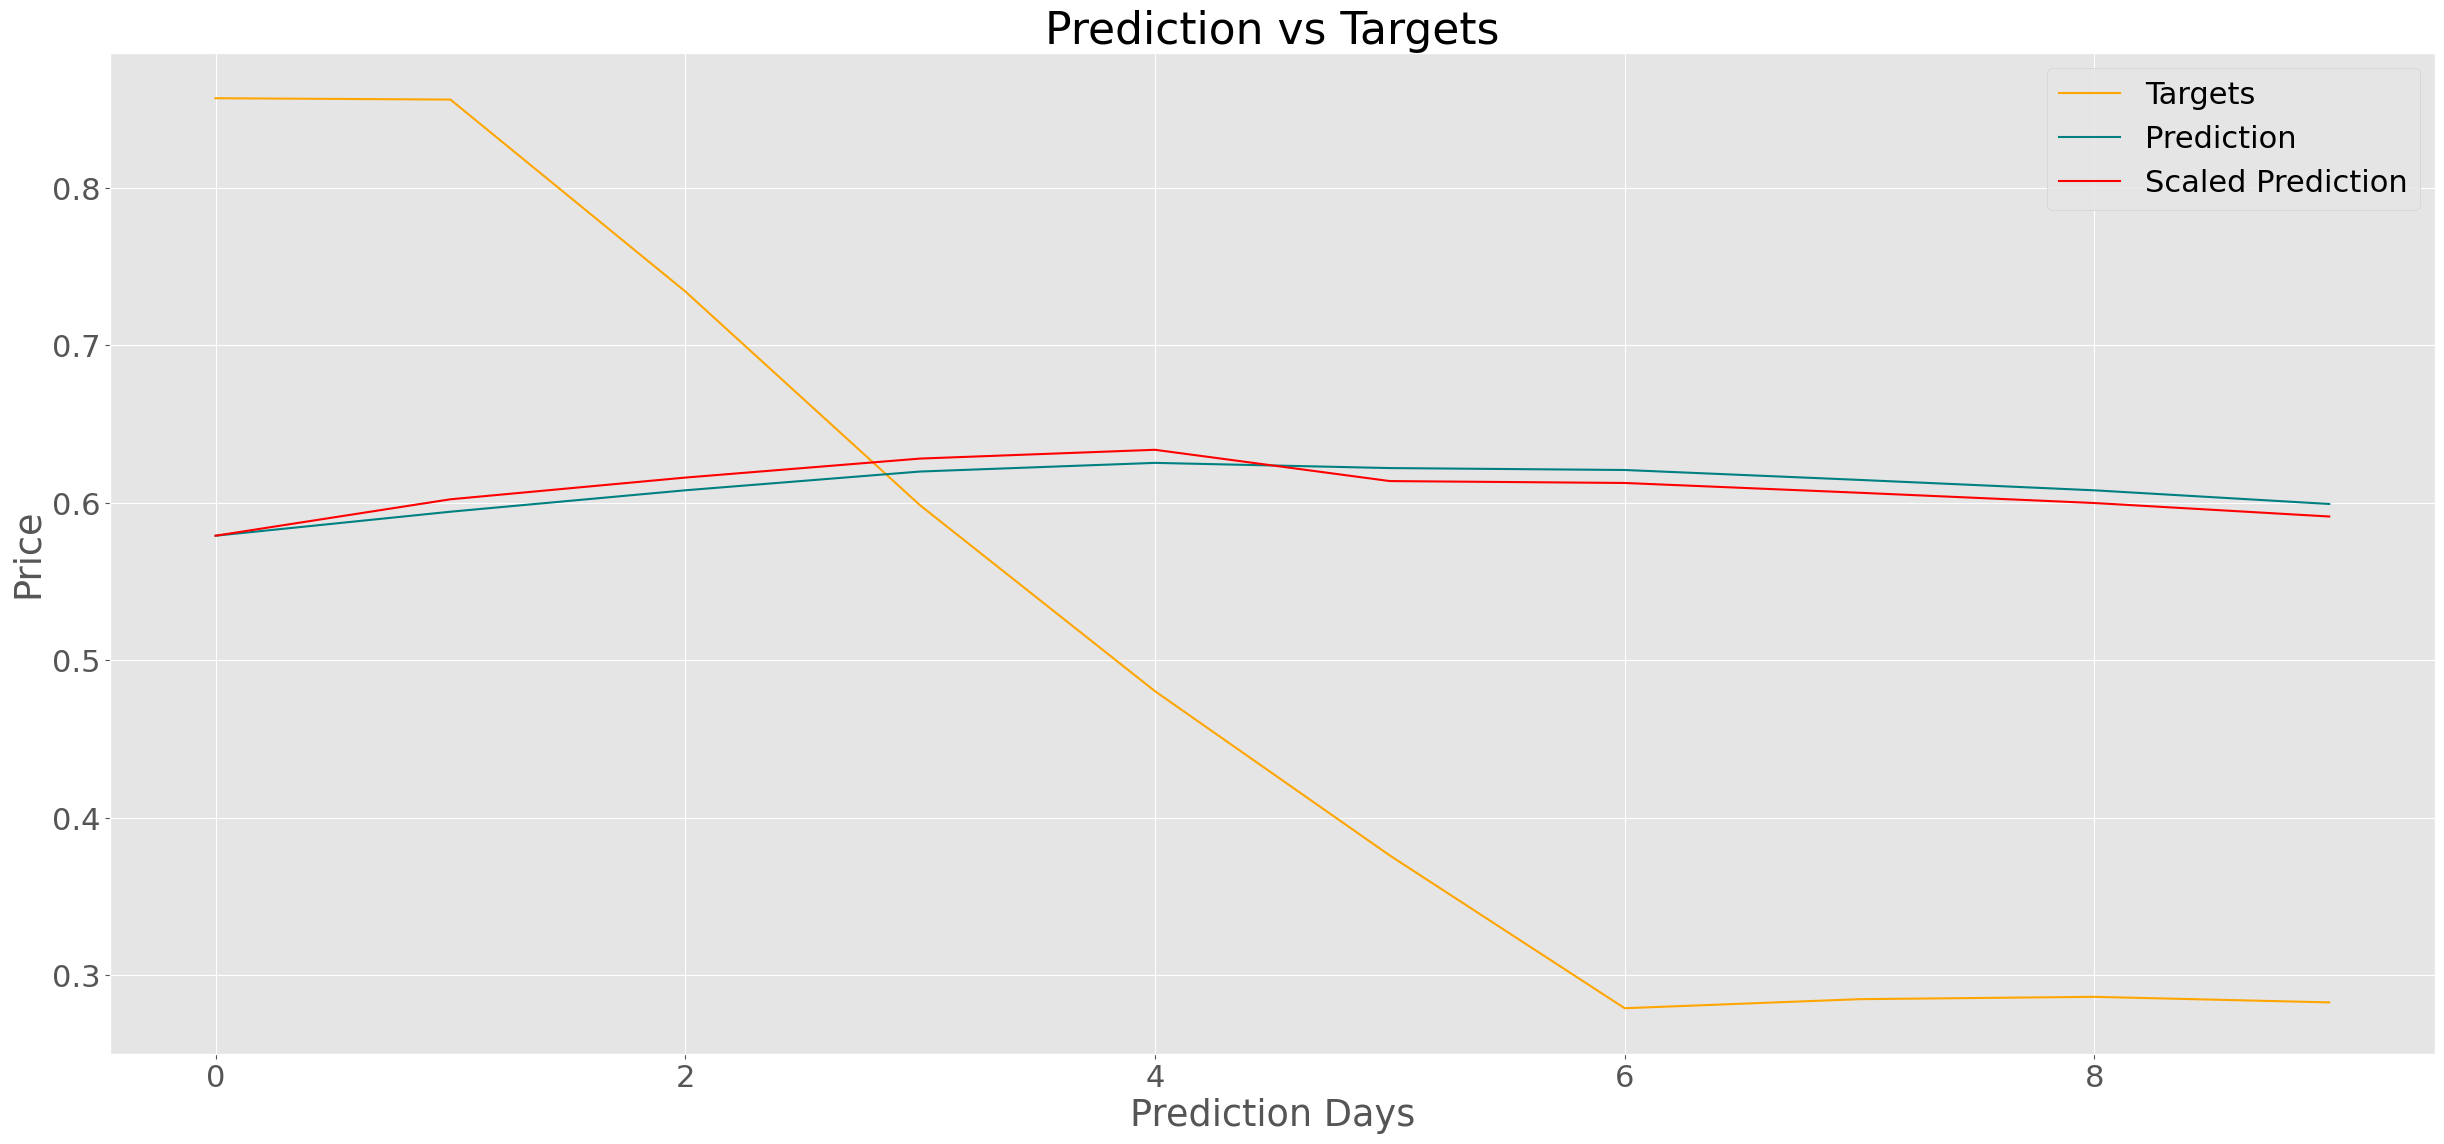

In [88]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(30, 13))
ax.set_title("Prediction vs Targets")
ax.plot(test_data.result['y_test'], color='orange', label='Targets')
ax.plot(prediction, color='teal', label='Prediction')
ax.plot(scaled_pred, color='red', label='Scaled Prediction')
ax.legend(loc='upper right')

ax.set_xlabel('Prediction Days')
ax.set_ylabel('Price')

plt.show()